# Introduction

This notebook will investigate how cloud coverage data (from NOAA-CDO-Local Climate Data) and irradiance data (from SNL RTC Met Station) agree.  If cloud coverage data matches well with irradiance data (in an expected way), this could be use for training machine learning models to detect cloudy and clear sky periods.

# Imports, configs, etc

In [1]:
import numpy as np
import pandas as pd
import datetime
import pvlib

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

# Load/merge weather and performance data

Weather cloud coverage data is given by NOAA CDO (Local Climate Data (LCD), https://www.ncdc.noaa.gov/cdo-web/datasets).  SNL RTC data was gotten from PVDAQ website (run by NREL).

In [2]:
met_file = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1405_weather_for_1429.csv')
pv_file = os.path.expanduser('~/data_sets/snl_raw_data/1429_1405/raw_1429.csv')
lcd_file = os.path.expanduser('~/data_sets/cdo/ABQ_LCD.csv')

In [3]:
met_cols = ['Diffuse_Wm2', 'Direct_Wm2', 'Global_Wm2', 'Date-Time']
pv_cols = ['inv1_ac_power', 'inv2_ac_power', 'poa_irradiance', 'Date-Time']
lcd_cols = ['DATE', 'REPORTTPYE', 'HOURLYSKYCONDITIONS', 'HOURLYVISIBILITY', 'HOURLYPRSENTWEATHERTYPE']

In [4]:
met_data = pd.read_csv(met_file, parse_dates=['Date-Time'], usecols=met_cols, index_col=['Date-Time'])

In [5]:
pv_data = pd.read_csv(pv_file, parse_dates=['Date-Time'], usecols=pv_cols, index_col=['Date-Time'])

In [6]:
snl_data = pv_data.join(met_data)

In [7]:
snl_data.index = snl_data.index.tz_localize('Etc/GMT+7')

In [8]:
lcd_data = pd.read_csv(lcd_file, parse_dates=['DATE'], usecols=lcd_cols, index_col=['DATE'])

/Users/benellis/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
lcd_data.index = lcd_data.index.tz_localize('Etc/GMT+7')

In [10]:
lcd_data.head()

,REPORTTPYE,HOURLYSKYCONDITIONS,HOURLYVISIBILITY,HOURLYPRSENTWEATHERTYPE
DATE,,,,
2015-01-01 00:52:00-07:00,FM-15,SCT:04 200 BKN:07 300,10,NaN
2015-01-01 01:52:00-07:00,FM-15,SCT:04 43 BKN:07 130,10,NaN
2015-01-01 02:00:00-07:00,FM-12,41,NaN,NaN
2015-01-01 02:52:00-07:00,FM-15,FEW:02 30 BKN:07 43 OVC:08 85,10,NaN
2015-01-01 03:52:00-07:00,FM-15,BKN:07 32 BKN:07 85 OVC:08 130,10,NaN


FM-15 is a 'METAR Aviation routine weather report' and FM-12 is a 'SYNOP Report of surface observation form a fixed land station' https://www1.ncdc.noaa.gov/pub/data/ish/ish-format-document.pdf.  Not sure which would be better/preferred for this work.  For now, will use FM-15 METAR format.

In [11]:
lcd_data = lcd_data[lcd_data['REPORTTPYE'] == 'FM-15']

Rounding data to nearest hour (8 min change).

In [12]:
lcd_data.index = lcd_data.index.round('1H')

# Utility functions for extracting cloud coverage data from METAR format

Need methods for getting amount of cloud layer (in okta).

In [13]:
class SkyCondition(object):
    
    def __init__(self, layers):
        import copy
        self.layers = copy.deepcopy(layers)
    
    def __str__(self):
        val = ''
        for layer in self.layers:
            val += '{}: {}, {}: {}, {}: {} \n'.format('Coverage', layer['coverage'], 
                                                      'Layer Amt', layer['layer_amt'],
                                                      'Height', layer['height'])
        return val
    
    @classmethod
    def from_METAR(cls, metar_str):
        '''
        Parse METAR for sky conditions (assumes only receives sky conditions).
        METAR sky conditions are given by XXX:LL N
            XXX describes the cloud coverage (CLR: clear, FEW: few clouds, SCT: scattered clouds, 
                BKN: broken clouds, OVC: overcast, VV: obscured sky, 10, partially obscured)
            LL describes the layer amount in oktas (0-8, 8 being complete cloud cover)
                00: CLR, 01-02: FEW, 03-04: SCT, 05-07: BRK, 08: OVC, 09-10: VV (partially) obscured sky
            N describes heigh of clouds in hundreds of ft.  This will be converted to feet.
        '''
        metar_list = metar_str.strip().split()
    
        if len(metar_list) <= 2:
            raise ValueError('METAR sky condition must be at least length 2 using XXX:LL N format.')
        
        layers = []
        for layer in range(0, len(metar_list), 2):
            this_layer = metar_list[layer: layer + 2]
            coverage, layer_amt = this_layer[0].split(':')
            layer_amt = int(layer_amt)
            height = int(this_layer[1]) * 100
            this_layer = {'coverage': coverage,
                          'layer_amt': layer_amt,
                          'height': height}
            layers.append(this_layer)
        
        return(cls(layers))

In [14]:
def get_max_layer_amt(x):
    try:
        sky = SkyCondition.from_METAR(x)
        layer_amts = [i['layer_amt'] for i in sky.layers]
        if len(layer_amts) == 0:
            return 0
        return np.max(layer_amts)
    except:
        return 0

In [15]:
def get_min_layer_amt(x):
    try:
        sky = SkyCondition.from_METAR(x)
        layer_amts = [i['layer_amt'] for i in sky.layers]
        if len(layer_amts) == 0:
            return 0.
        return np.min(layer_amts)
    except:
        return 0   

In [16]:
def get_avg_layer_amt(x):
    try:
        sky = SkyCondition.from_METAR(x)
        layer_amts = [i['layer_amt'] for i in sky.layers]
        return np.sum(layer_amts) / 3
    except:
        return 0

In [17]:
def map_layer_amt_to_coverage(x):
    if x < 1:
        return 'CLR'
    elif x >= 1 and x <= 2:
        return 'FEW'
    elif x > 2 and x <= 4:
        return 'SCT'
    elif x > 4 and x <= 7:
        return 'BKN'
    elif x > 7 and x <= 8:
        return 'OVC'
    else:
        return 'VV'

#### Get layer amount for sky conditions (min/max/avg)

In [18]:
lcd_data['max_layer_amt'] = lcd_data['HOURLYSKYCONDITIONS'].apply(get_max_layer_amt)
lcd_data['coverage_from_max'] = lcd_data['max_layer_amt'].apply(map_layer_amt_to_coverage)

In [19]:
lcd_data['min_layer_amt'] = lcd_data['HOURLYSKYCONDITIONS'].apply(get_min_layer_amt)
lcd_data['coverage_from_min'] = lcd_data['min_layer_amt'].apply(map_layer_amt_to_coverage)

In [20]:
lcd_data['avg_layer_amt'] = lcd_data['HOURLYSKYCONDITIONS'].apply(get_avg_layer_amt)
lcd_data['coverage_from_avg'] = lcd_data['avg_layer_amt'].apply(map_layer_amt_to_coverage)

# Set up PVSystem for detecting clear sky periods using PV_Lib

In [21]:
site_azimuth = 180
site_elevation = 1658
site_tilt = 35
site_lat = 35.0549
site_lon = -106.5433

In [22]:
rtc_no_loc = pvlib.pvsystem.PVSystem(surface_tilt=site_tilt, surface_azimuth=site_azimuth)
rtc_loc = pvlib.location.Location(site_lat, site_lon, altitude=site_elevation)
rtc = pvlib.pvsystem.LocalizedPVSystem(pvsystem=rtc_no_loc, location=rtc_loc)

# GHI and cloud layer analysis

### Sample 1: July

In [23]:
start_date = '2016-06-01'
end_date = '2016-07-01'
sample_snl = snl_data[(snl_data.index >= start_date) & (snl_data.index <= end_date)].copy()
sample_lcd = lcd_data[(lcd_data.index >= start_date) & (lcd_data.index <= end_date)].copy()

In [24]:
clear_skies = rtc_loc.get_clearsky(sample_snl['Global_Wm2'].index)

In [25]:
sample_snl.fillna(sample_snl.interpolate(), inplace=True)

In [26]:
is_clear = pvlib.clearsky.detect_clearsky(sample_snl['Global_Wm2'], clear_skies['ghi'], 
                                          sample_snl['Global_Wm2'].index, 10)

In [27]:
sample = sample_snl.join(sample_lcd)

In [28]:
sample.fillna(method='ffill', inplace=True)

<IPython.core.display.Javascript object>


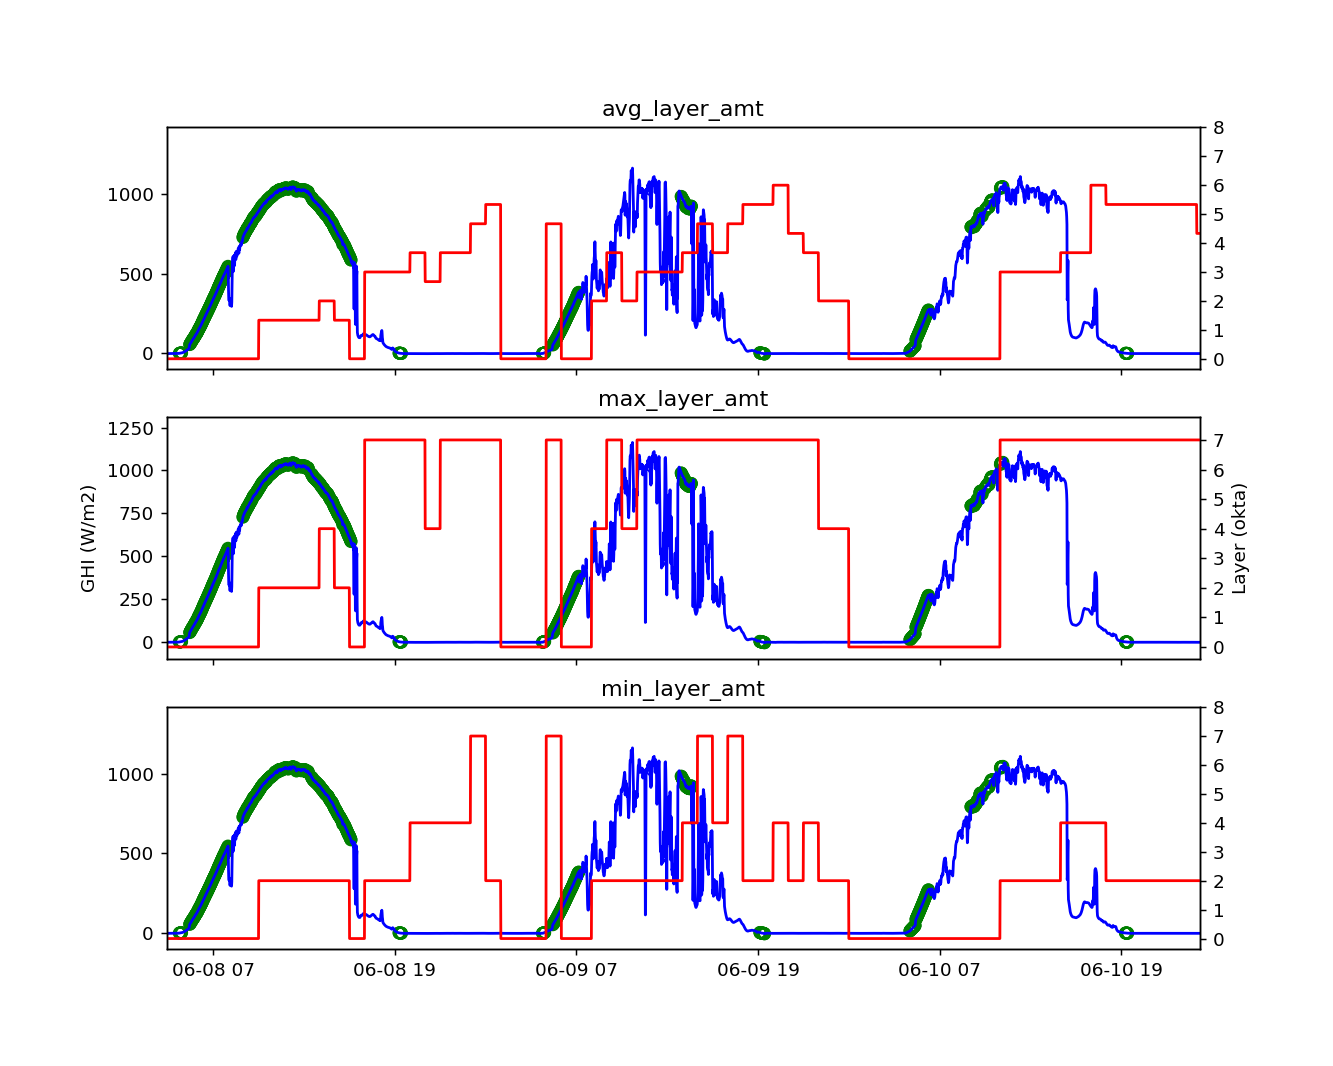

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

for i, (ax, key) in enumerate(zip(axes, ['avg_layer_amt', 'max_layer_amt', 'min_layer_amt'])):
    ax.plot(sample.index, sample['Global_Wm2'], c='b', label='GHI')
    ax.scatter(sample_snl[is_clear].index, sample_snl['Global_Wm2'][is_clear], marker='o', 
               facecolor='none', edgecolor='g')
    if i == 1:
        ax.set_ylabel('GHI (W/m2)')
    ax2 = ax.twinx()
    ax2.plot(sample.index, sample[key], c='r', label=key)
    ax2.set_title(key)
    ax2.set_yticks(list(range(9)))
    if i == 1:
        ax2.set_ylabel('Layer (okta)')

### Sample 2: January

In [30]:
start_date = '2017-02-01'
end_date = '2017-03-01'
sample_snl = snl_data[(snl_data.index >= start_date) & (snl_data.index <= end_date)].copy()
sample_lcd = lcd_data[(lcd_data.index >= start_date) & (lcd_data.index <= end_date)].copy()

Note: there are many missing/unequal times in this data set.  This will need to be addressed so detecting clear skies doesn't choke with missing dates.  Right now, the time periods that give errors are being avoided.

In [31]:
clear_skies = rtc_loc.get_clearsky(sample_snl['Global_Wm2'].index)

In [32]:
sample_snl.fillna(sample_snl.interpolate(), inplace=True)

In [33]:
is_clear = pvlib.clearsky.detect_clearsky(sample_snl['Global_Wm2'], clear_skies['ghi'], 
                                          sample_snl['Global_Wm2'].index, 10)

In [34]:
sample = sample_snl.join(sample_lcd)

In [35]:
sample.fillna(method='ffill', inplace=True)

<IPython.core.display.Javascript object>


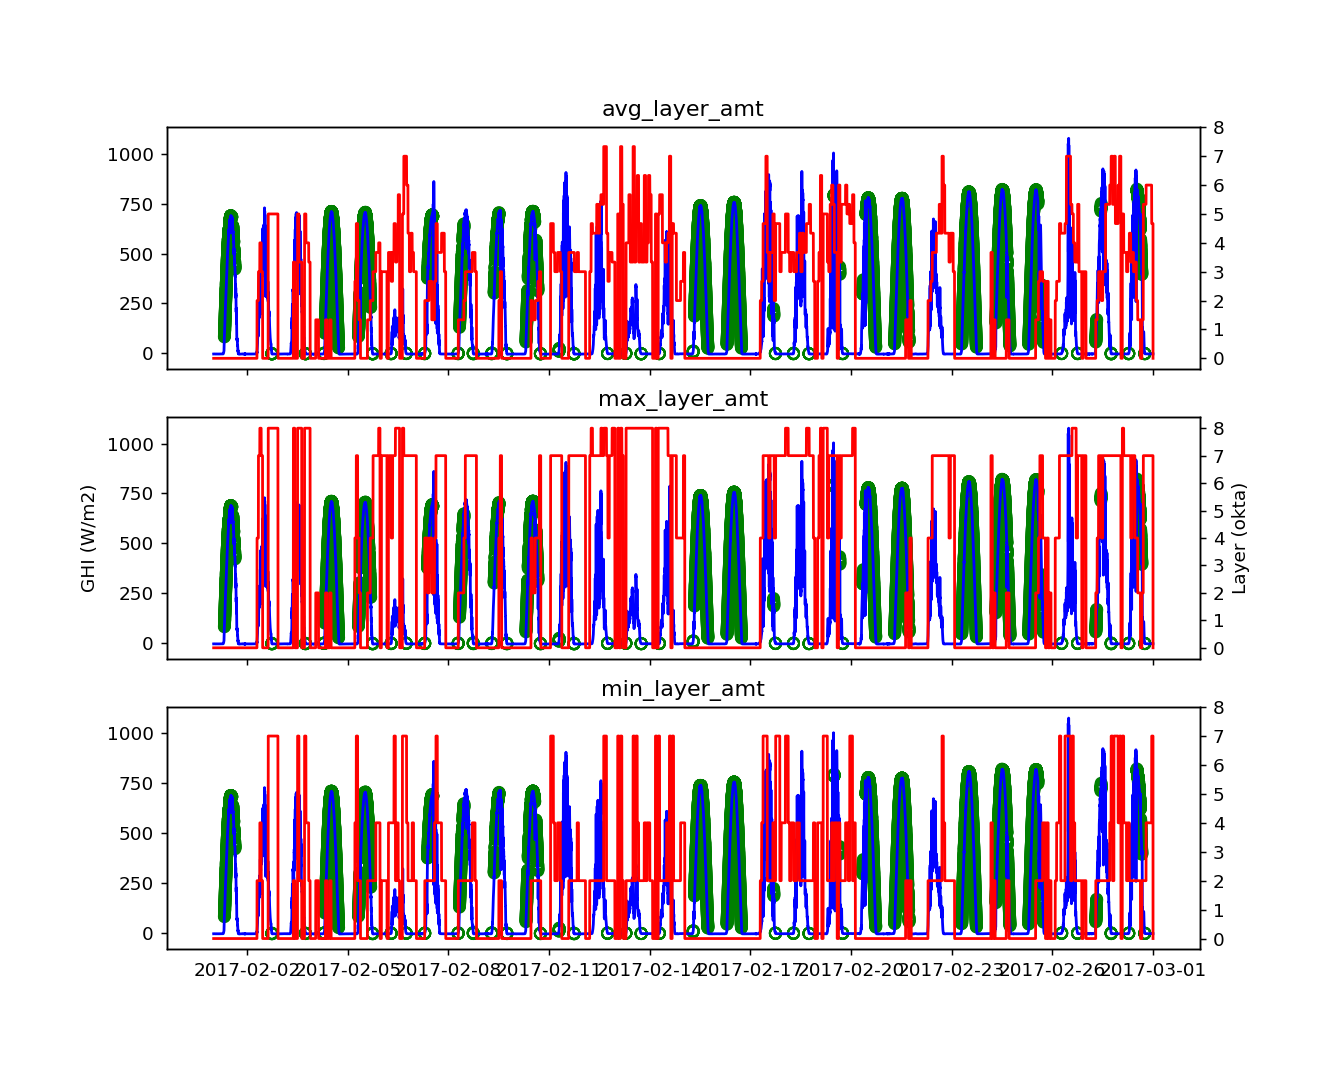

In [36]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

for i, (ax, key) in enumerate(zip(axes, ['avg_layer_amt', 'max_layer_amt', 'min_layer_amt'])):
    ax.plot(sample.index, sample['Global_Wm2'], c='b', label='GHI')
    ax.scatter(sample_snl[is_clear].index, sample_snl['Global_Wm2'][is_clear], marker='o', 
               facecolor='none', edgecolor='g')
    if i == 1:
        ax.set_ylabel('GHI (W/m2)')
    ax2 = ax.twinx()
    ax2.plot(sample.index, sample[key], c='r', label=key)
    ax2.set_title(key)
    ax2.set_yticks(list(range(9)))
    if i == 1:
        ax2.set_ylabel('Layer (okta)')

# Outlook

It seems at though cloud data gathered through CDO does not match up well with clear sky detection methods.  There are anecdotal periods where it looks very promising, and other times where complete cloud coverage is detected at clear sky periods.  There are a few potential causes of this.  

First, the SNL weather and the LCD weather are measured at different locations.  They are close to each other (roughly 4 miles, measured using Google Maps), but the distane may still be significant.  Second, clouds layer is measured once per hour, which is not detailed enough to correlate with changes in measured irradiance.  Again, there are anecdotal points where we see cloud cover increase and GHI decrease (or vice versa), but it's difficult to generalize.  Third,  it appears that cloud layer is never measured as less than two.  This is a problem that may need to be addressed.  It could be possible that clear periods are not recorded at all, so when HOURYSKYCONDITIONS is sparse or empty, it should have more 'clear' periods.  This has been considered and 'corrected' now.  When reading METAR, an assumption is made that there should be 3 measurements (documenation says that up to 3 measurements are recorded for sky conditions), so  any missing conditions are assumed clear).

To do: learn how HOURLYSKYCONDITIONS are recorded.  Of greatest interest: should there always be a certain number of measurements for different bins of cloud height?  For example, should there always be three measurements, but CLR periods are omitted?  Or is the number of cloud measurements nebulous and we cannot assume clear periods if data is not reported.  Research other cloud based data to learn how it correlates with irradiance measures.  